# Daylight Savings Legislation

Steps for this project:
- Scrape this website: https://www.ncsl.org/research/transportation/daylight-savings-time-state-legislation.aspx
- Create map that shows: which states have bills, whether it will change to DST or EST
- Similar map to put next to it that shows 2021
- Create bar chart (or other type of chart) that shows status of the bill, something more detailed than "pending"

Questions/things to figure out:
- How do I differentiate my visualizations from what's already available on the NCSL?
- Where do I find info/data on Congressional rather than state legislation? (perhaps https://www.govtrack.us/congress/bills/browse?congress=117&text=daylight%20savings#sort=relevance but would have to manually check results)

- grid chart (x-y)
- farming vs. bills
- check for duplicate bills

=IMPORTHTML in google sheets

In [122]:
import pandas as pd
from bs4 import BeautifulSoup
import requests
from plotnine import *
import re
import time

## Legislation

Scraping the National Conference of State Legislature's [data](https://www.ncsl.org/research/transportation/daylight-savings-time-state-legislation.aspx) on state bills to change clock-switching. 

In [123]:
url = 'https://www.ncsl.org/research/transportation/daylight-savings-time-state-legislation.aspx'

In [124]:
raw_html = requests.get(url).content
soup = BeautifulSoup(raw_html, "html.parser")

In [125]:
def scrape_table(index, year):
    html = soup.find_all('table')[index]
    table = []
    for i, tr in enumerate(html.find_all('tr')[1:]):
        row = {}
        try:
            row['state'] = tr.find_all('td')[0].get_text()
            if row['state'] == u'\xa0':
                row['state'] = table[i-1]['state']
            row['bill_no'] = tr.find_all('td')[1].get_text()
            row['primary_sponsor'] = tr.find_all('td')[2].get_text()
            row['status'] = tr.find_all('td')[3].get_text()
            row['summary'] = tr.find_all('td')[4].get_text()
            try: 
                row['bill_link'] = tr.find_all('td')[1].find('a')['href']
            except: #If bill doesn't have hyperlink, skip
                pass
            table.append(row)
        except: #If there's more than one bill per state (2021 and 2022), shift indexes of cells
            row['state'] = table[i-1]['state']
            row['bill_no'] = tr.find_all('td')[0].get_text()
            row['primary_sponsor'] = tr.find_all('td')[1].get_text()
            row['status'] = tr.find_all('td')[2].get_text()
            try: 
                row['summary'] = tr.find_all('td')[3].get_text()
            except: #If multiple bills do the same thing, use summary from previous row
                row['summary'] = table[i-1]['summary']
            try:
                row['bill_link'] = tr.find_all('td')[0].find('a')['href']
            except: #If bill doesn't have hyperlink, skip
                pass
            table.append(row)
    table_clean = []
    for row in table:
        row_clean = {}
        for index, cell in enumerate(row.values()):
            cell = cell.replace('\n', '').replace('\t', '')
            row_clean[list(row.keys())[index]] = cell
        table_clean.append(row_clean)
    df = pd.DataFrame(table_clean)
    df['year'] = year
    return df

In [126]:
#Index is based on table placement on the webpage; they are in reverse chronological order here
state_bills22 = scrape_table(0, 2022) 
state_bills21 = scrape_table(1, 2021)
state_bills20 = scrape_table(2, 2020)

In [127]:
all_years = pd.concat([state_bills22, state_bills21, state_bills20])

In [128]:
def clean_table(table):
    table.loc[table.primary_sponsor.str.contains('R-'), 'party'] = 'R'
    table.loc[table.primary_sponsor.str.contains('D-'), 'party'] = 'D'
    table.loc[table.primary_sponsor.str.contains('I-'), 'party'] = 'I'
    table.bill_no = table.bill_no.str.replace(' \(', '(')

In [129]:
clean_table(all_years)

/var/folders/tx/ryc062z51z1287rjpvrp4jlc0000gn/T/ipykernel_6558/2501339832.py:5: FutureWarning: The default value of regex will change from True to False in a future version.


In [130]:
year_totals = all_years.year.value_counts().reset_index(name='num_bills')

In [131]:
grid_data = all_years.groupby(['state', 'year']).year.count().reset_index(name='num_bills')[:130]

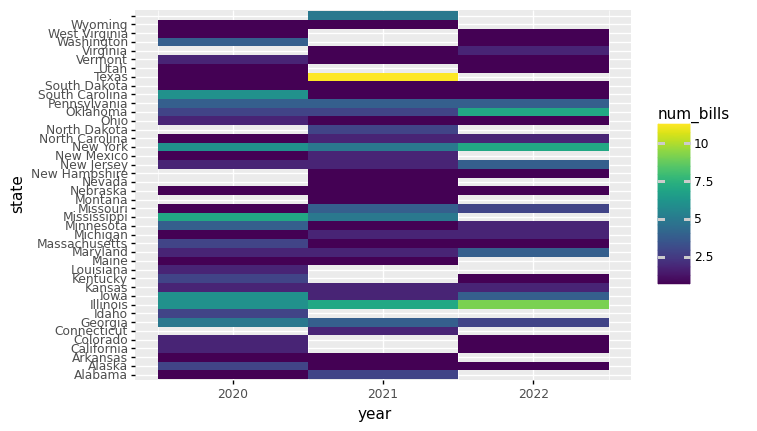

<ggplot: (330400793)>

In [132]:
display (
    ggplot(grid_data)
    + geom_tile(aes(x='year', y='state', fill='num_bills'))
)

In [133]:
outcomes = all_years.groupby(['state', 'status', 'year']).bill_no.count().reset_index(name='num_outcomes')

In [ ]:
outcomes.status.value_counts()

In [ ]:
outcomes.status = \
                outcomes.status.str.replace(r'\(.*', '').str.strip()\
                .str.replace('Failed Adjourned', 'Failed')\
                .str.replace('FailedAdjourned', 'Failed')\
                .str.replace('Failed-Adjourned, Failed')
                .str.replace('Amendment Failed', 'Failed')\
                .str.replace(r'2020.*', 'Enacted')\
                .str.replace('Adopted', 'Enacted')


In [136]:
enacted_states = outcomes[outcomes.status == 'Enacted']


In [137]:
outcomes.drop(outcomes[(outcomes.status!='Enacted') \
                       & (outcomes.state.isin(list(enacted_states.state)))].index,\
                         inplace=True)

In [138]:
outcomes.drop(outcomes[outcomes.status == 'Pre-filed'].index, inplace=True)

In [139]:
outcomes = outcomes.sort_values('state')

In [140]:
outcomes = outcomes.sort_values('status')

In [ ]:
states = list(outcomes.state.unique())

tile_chart = (
    ggplot(outcomes)
    + geom_tile(aes(x='year', y='state', fill='status'), color = "white", size=0.2)#
    #+ coord_fixed()
    #+ scale_fill_manual(['#f2bf30', '#f5ecc4', '#f4dd93', '#f3ca55']) #enacted, failed, adjourned, pending
    + scale_fill_manual(['#A8E799', '#F89176', '#FAE688'])
    + theme_minimal()
    + scale_y_discrete(limits=states[::-1])
    + theme(panel_grid_major=element_blank(),
            panel_grid_minor=element_blank())
    + labs(title='28 states are considering legislation on Daylight Saving Time in 2022',
           x='', 
           y='')
)

display(tile_chart)

In [95]:
outcomes[outcomes.state == 'New Jersey']

,state,status,year,num_outcomes
62,New Jersey,Failed-Adjourned,2021,2
63,New Jersey,Pending,2020,2
64,New Jersey,Pending,2022,4


In [142]:
all_years[all_years.state == 'New Jersey']

,state,bill_no,primary_sponsor,status,summary,bill_link,year,party
36,New Jersey,AB 1365(2022),Wimberly (D-35),Pending,Establishes DST as the official time year-roun...,NaN,2022,D
37,New Jersey,SB 946(2022),Turner (D-15),Pending,Establishes DST as the official time year-roun...,NaN,2022,D
38,New Jersey,SB 420(2020),Turner (D-15),Pending,Establishes DST as the official time year-roun...,NaN,2022,D
39,New Jersey,AB 3868(2020),Wimberly (D-35),Pending,Establishes DST as the official time year-roun...,NaN,2022,D
47,New Jersey,SB 420(2020),Turner (D-15),Failed Adjourned,Establishes DST as the official time year-roun...,https://www.njleg.state.nj.us/2020/Bills/S0500...,2021,D
48,New Jersey,AB 3868(2020),Wimberly (D-35),Failed Adjourned,Establishes DST as the official time year-roun...,https://www.njleg.state.nj.us/2020/Bills/A4000...,2021,D
56,New Jersey,SB 420(2020),Turner,Pending,Establishes DST as the official time year-roun...,https://www.njleg.state.nj.us/2020/Bills/S0500...,2020,NaN
57,New Jersey,AB 3868(2020),Wimberly,Pending,Establishes DST as the official time year-roun...,https://www.njleg.state.nj.us/2020/Bills/A4000...,2020,NaN


In [547]:
tile_chart.save('states_tiles.svg')

/Users/jmingram/.pyenv/versions/3.10.0/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/jmingram/.pyenv/versions/3.10.0/lib/python3.10/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: states_tiles.svg


## Sunrise and Sunset

Steps:
1. Scrape lat long of US cities from https://www.latlong.net/category/cities-236-15-1.html
2. Create a function to pull sunrise/sunset times from https://sunrise-sunset.org/api on a given day
3. Adjust for time zones
4. Map what it would be like without daylight savings on that given day

In [ ]:
cities = []
for page in range(1,11):
    if page == 1:
        url_latlng = 'https://www.latlong.net/category/cities-236-15.html'
    else:
        url_latlng = 'https://www.latlong.net/category/cities-236-15-' + str(page) + '.html'
    raw_html_latlng = requests.get(url_latlng).content
    soup_latlng = BeautifulSoup(raw_html_latlng, "html.parser")
    for row in soup_latlng.find_all('tr')[1:]:
        city = {}
        city['name'] = row.find_all('td')[0].get_text()
        city['lat'] = row.find_all('td')[1].get_text()
        city['lng'] = row.find_all('td')[2].get_text()
        cities.append(city)
cities_geo = pd.DataFrame(cities)

In [243]:
cities_geo = cities_geo.drop_duplicates()

In [244]:
cities_geo['request_url'] = 'https://api.sunrise-sunset.org/json?lat=' \
                            + cities_geo.lat + '&lng=' + cities_geo.lng + '&date=2022-01-01'   

/var/folders/tx/ryc062z51z1287rjpvrp4jlc0000gn/T/ipykernel_6558/480063168.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [247]:
def get_sunrise(url):
    time.sleep(0.2)
    return pd.read_json(url).iat[8,0]
def get_sunset(url):
    time.sleep(0.2)
    return pd.read_json(url).iat[9,0]

In [ ]:
#Takes a few minutes
cities_geo['sunrise_2022-01-01'] = cities_geo.request_url.apply(lambda x:get_sunrise(x))

In [ ]:
#Takes a few minutes
cities_geo['sunset_2022-01-01'] = cities_geo.request_url.apply(lambda x:get_sunset(x))

In [ ]:
cities_geo['sunrise_2022-01-01'] = pd.to_datetime(cities_geo['sunrise_2022-01-01'])
cities_geo['sunset_2022-01-01'] = pd.to_datetime(cities_geo['sunset_2022-01-01'])

In [ ]:
#!pip install timezonefinder[numba] 
from timezonefinder import TimezoneFinder
tf = TimezoneFinder()

In [ ]:
from datetime import timedelta

In [ ]:
def adjust_timezone_DST(place, latitude, longitude, time):
    timezone = tf.timezone_at(lng=float(longitude), lat=float(latitude))
    if timezone == 'America/Los_Angeles':
        return time - timedelta(hours=7)
    elif timezone == 'America/Boise':
        return time - timedelta(hours=6)
    elif timezone == 'America/Chicago':
        return time - timedelta(hours=5)
    elif timezone == 'America/New_York':
        return time - timedelta(hours=4)

In [ ]:
cities_geo['sunrise_2022-01-01'] = cities_geo.apply(lambda x:adjust_timezone_DST(x.name, x.lat, x.lng, x['sunrise_2022-01-01']), axis=1)
cities_geo['sunset_2022-01-01'] = cities_geo.apply(lambda x:adjust_timezone_DST(x.name, x.lat, x.lng, x['sunset_2022-01-01']), axis=1)

In [ ]:
cities_geo.to_csv('cities_geo_sunrise_sunset_JanDST.csv')